# 2019-nCov Analysis, Assessing the Surge Capacity
### Affan Shoukat

The script reads the output files from the general model defined in `ncov_ode_model.jl` and plots the results for the manuscript. 

In [1]:
# load packages
using Distributions, DataFrames, CSV, Query, VegaLite, LsqFit, Plots, PrettyTables, StatsPlots, Interpolations
using Base.Iterators, Random
pyplot()
#PyPlot.svg(true)
pwd()

┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1273
┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


"/Users/abmlab/OneDrive/Documents/postdoc projects/2019-ncov/scripts/ode_model"

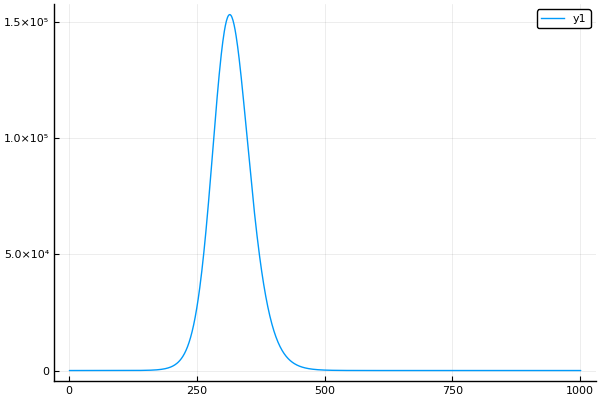

total maximum:[510.53751016099164, 29692.773861445065, 44502.92347397499, 79163.07841597112]
total maximum:152960.64635263468
total maximum:152960.64635263468


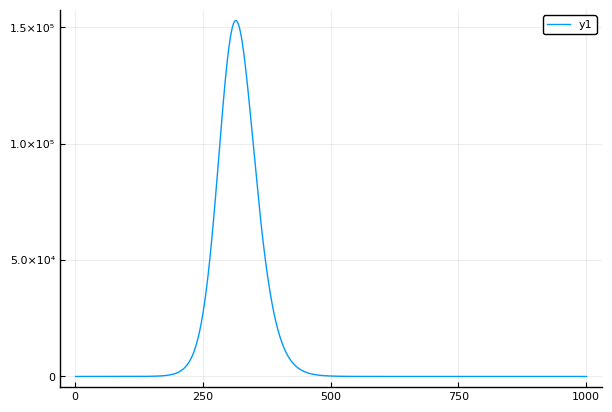

[78369.9911324465, 201612.36191049477]
maximum: 152960.64635263468, (133750.27820940773, 179610.97610325192)


In [107]:
r02 = "b00493"
r025 = "b00616"
r0 = r02
dloc = "/Users/abmlab/Documents/data/pnas_revisions/$r0/v00"
s1 = "tau00_f00"
ci = [CSV.read("$dloc/$s1/icu$i.csv", header=["mc$i" for i = 1:100]) for i =1:4]
     
#mn = mean.(eachrow.(ci))

## takes the average of 1000 simulations in each row. 
means = [mean.(x) for x in eachrow.(ci)]
println("total maximum:$(maximum.(means))")
plot(means)

sumags = sum(means) ## sum of all age groups
display(plot(sumags))
println("total maximum:$(maximum(sumags))")


#thin out the array and look at 7 day intervals
totalweeks = Int(floor(round(length(sumags)/7)))
weekidx = [7*x for x = 1:totalweeks]
plot(sumags[weekidx])
println("total maximum:$(maximum(sumags[weekidx]))")

## this is the same thing as above, but converts the 4 age specific dataframes into a matrix format (all age groups added together)
nsims = 100
dfmat = zeros(Float64, 1001, nsims)
for i in 1:100 
   dfmat[:, i] = ci[1][:, i] + ci[2][:, i] + ci[3][:, i] + ci[4][:, i]
end
mat_means = mean.(eachrow(dfmat))
plot(mat_means)
maxvalue = maximum(mat_means)

## gives us the time when the peak occurs
peak = findall(x -> x == maxvalue, mat_means)
## lets go back to dfmat raw data and find the quantiles of each simulation at the peak time
## this is somewhat flawed.. the peak may be different for each simulation.. not exactly at `peak` time
println(quantile(vec(dfmat[peak, :]), [0.025, 0.975]))


## i think what we have to do is thake the quantiles of each row
mat_quant_lo = quantile.(eachrow(dfmat), 0.25)
mat_quant_hi = quantile.(eachrow(dfmat), 0.75)
maxlo = maximum(mat_quant_lo)
maxhi = maximum(mat_quant_hi)

println("maximum: $maxvalue, ($maxlo, $maxhi)")

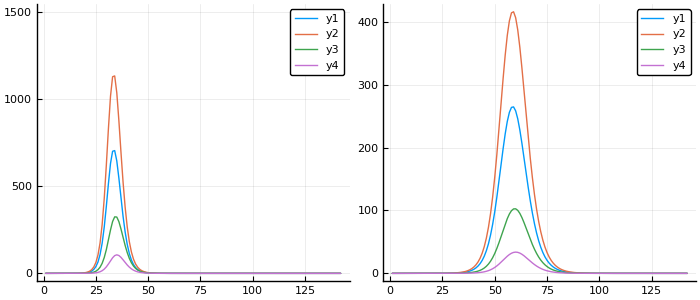

In [238]:

# do with s1 ie. 2 days, 5%

function getwinc(sstr) 
    ci = [CSV.read("$dloc/$sstr/ci$i.csv", header=["mc$i" for i = 1:100]) for i =1:4]
    cols = eachcol.(ci)
    minc = []
    for a in ci 
        getcols = collect(eachcol(a))    
        inc = circshift.(getcols, -1) .- getcols
        pop!.(inc)
        mn = mean.(eachrow(DataFrame(inc)))
        push!(minc, mn)
    end
    #plot(minc)
    #add up at weekly level
    winc = []
    for j = 1:4 
        push!(winc, [sum(minc[j][(7*i - 6):(7*i)]) for i = 1:nweek])
    end
    return minc, winc
end
s1winc = getwinc(s1)[2]
s2winc = getwinc(s2)[2]
l = @layout [a b;] 
p1 = plot(1:nweek, s1winc./10000, ylim=[0, 1500])
p2 = plot(1:nweek, s2winc./10000)
plot(p1, p2, layout=l, size=(700, 300))


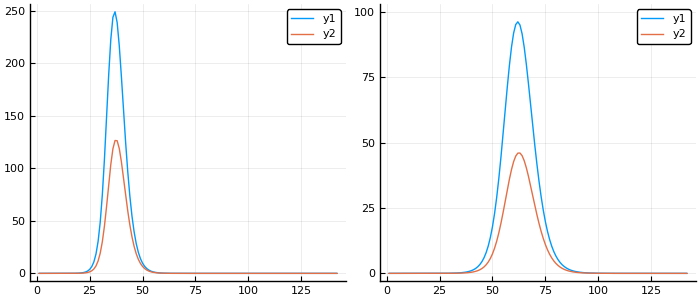

In [243]:
### icu bed occupancy
function icubedocc(str)
    ci = [CSV.read("$dloc/$str/icu$i.csv", header=["mc$i" for i = 1:100]) for i =1:4]
    minc = []
    for a in ci    
        mn = mean.(eachrow(a))
        push!(minc, mn)
    end
    winc = []
    for j = 1:4 
        push!(winc, [sum(minc[j][(7*i - 6):(7*i)]) for i = 1:nweek])
    end
    m = hcat(winc...)
    #msum = sum(m, dims=2)    
    return m
end
icu1m = icubedocc(s1)
icu1all = sum(icu1m, dims=2) ## all age groups added 
icu150 = sum(icu1m[:, 3:4], dims=2) ## only 50+ years of age


icu2m = icubedocc(s2)
icu2all = sum(icu2m, dims=2) ## all age groups added 
icu250 = sum(icu2m[:, 3:4], dims=2) ## only 50+ years of age

l = @layout [a b;] 
p1 = plot(1:nweek, [icu1all, icu150]./1000)
p2 = plot(1:nweek, [icu2all, icu250]./1000, ylim=[0, 100])
plot(p1, p2, layout=l, size=(700, 300))


In [265]:
ci = [CSV.read("$dloc/$s1/ch$i.csv", header=["mc$i" for i = 1:100]) for i =1:4]
minc = []
for a in ci    
        mn = mean.(eachrow(a))
        push!(minc, mn)
    end
lastval = [minc[i][end] for i = 1:4 ]
lastval ./ (81982665,129596376,63157200,52431193) 

4-element Array{Float64,1}:
 0.015868571169361904
 0.01583712563166976 
 0.010951126287208903
 0.006440325901222035

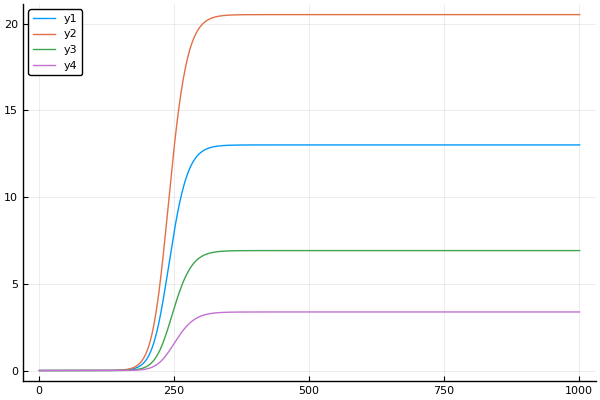